# LangGraph V1.0 시작하기

이 노트북에서는 LangGraph V1.0의 핵심 기능들을 실습을 통해 배워봅니다.

**학습 목표:**
- LangGraph 에이전트 생성 및 설정
- 도구(Tool) 정의 및 활용
- 컨텍스트 관리와 상태 유지
- 구조화된 응답 생성
- 메모리를 통한 대화 기록 관리
- 미들웨어를 활용한 승인 워크플로우

**실습 도메인:** 전자상거래 고객 서비스 챗봇

## 1. 환경 설정

먼저 필요한 환경 변수를 설정합니다. `.env` 파일에 API 키를 추가해야 합니다.

```env
OPENAI_API_KEY=your-key-here
LANGCHAIN_API_KEY=your-key-here
LANGCHAIN_TRACING_V2=true
```

In [1]:
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv(override=True)

True

In [2]:
from utils import logging

# LangSmith 추적 시작
logging.langsmith("01-langgraph-v1-intro")

LangSmith 추적을 시작합니다.
[프로젝트명]
01-langgraph-v1-intro


## 2. 모델 초기화

LangChain의 `init_chat_model` 함수를 사용하면 다양한 LLM 제공자의 모델을 통합된 방식으로 초기화할 수 있습니다.

### 모델 지정 방식

**기본 방식:** 모델 이름만 지정
```python
"gpt-4"
"claude-3-sonnet"
```

**통합 방식:** 제공자와 모델을 함께 지정
```python
"openai:gpt-4"
"anthropic:claude-3-sonnet"
"azure_openai:gpt-4"
```

### 주요 매개변수
- **temperature**: 출력의 창의성 조절 (0.0 = 결정적, 1.0 = 창의적)
- **max_tokens**: 생성할 최대 토큰 수
- **timeout**: 응답 대기 시간 (초)
- **max_retries**: 실패 시 재시도 횟수

In [3]:
from langchain.chat_models import init_chat_model

# GPT-4.1 모델 초기화 (온도를 0으로 설정하여 일관된 응답 생성)
llm = init_chat_model("openai:gpt-4.1", temperature=0, max_tokens=2000)

In [4]:
from utils.messages import stream_response

# 모델 테스트
result = llm.stream("AI Agent가 무엇인지 한 문장으로 설명해주세요.")
stream_response(result)

AI Agent란 주어진 목표를 달성하기 위해 환경을 인식하고, 판단하며, 자율적으로 행동하는 인공지능 시스템입니다.

## 3. 기본 에이전트 생성

LangGraph V1.0에서는 `create_agent` 함수를 사용하여 에이전트를 생성합니다.

에이전트는 사용자의 요청을 이해하고, 필요한 도구를 선택하며, 적절한 응답을 생성하는 지능형 시스템입니다.

In [5]:
from langchain.agents import create_agent

# 도구 없이 기본 에이전트 생성
basic_agent = create_agent(
    model="openai:gpt-4.1",
    tools=[],
    system_prompt="당신은 친절한 쇼핑 도우미입니다.",
)

### 에이전트 그래프 시각화

에이전트의 내부 구조를 시각화하여 데이터 흐름을 이해할 수 있습니다.

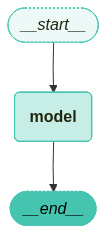

In [6]:
from utils.graphs import visualize_graph

visualize_graph(basic_agent)

In [7]:
from utils.messages import stream_graph
from langchain_core.messages import HumanMessage

# 기본 대화 테스트
stream_graph(
    basic_agent,
    inputs={"messages": [HumanMessage(content="안녕하세요! 당신은 누구인가요?")]},
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 저는 여러분의 쇼핑을 도와드릴 친절한 쇼핑 도우미입니다. 제품 추천, 비교, 구매 팁, 가격 정보 등 쇼핑과 관련된 다양한 질문에 답변해드릴 수 있어요. 궁금한 점이 있으시면 언제든 편하게 말씀해 주세요! 😊

## 4. 도구(Tool) 정의하기

도구는 에이전트가 외부 시스템이나 데이터와 상호작용할 수 있게 해주는 함수입니다.

### 실습: 전자상거래 고객 서비스 도구

고객 서비스 챗봇을 위한 세 가지 도구를 만들어봅니다:
1. **제품 검색**: 카테고리별 제품 찾기
2. **주문 조회**: 주문 번호로 배송 상태 확인
3. **추천 받기**: 사용자 선호도 기반 제품 추천

### 데이터 베이스 생성

In [10]:
from typing import TypedDict, List

class Product(TypedDict):
    """Product information schema."""
    name: str
    price: int
    rating: float

class Order(TypedDict):
    """Order information schema."""
    status: str
    item: str
    delivery_date: str

# 가상의 제품 데이터베이스
PRODUCT_DB: dict[str, List[Product]] = {
    "전자기기": [
        {"name": "아이폰 17 Pro", "price": 1990000, "rating": 4.5},
        {"name": "애플워치 Ultra", "price": 599000, "rating": 4.8},
        {"name": "맥북 프로 16인치 M4", "price": 3490000, "rating": 4.9},
        {"name": "아이패드 프로 12.9", "price": 1590000, "rating": 4.7},
        {"name": "에어팟 맥스", "price": 769000, "rating": 4.6},
        {"name": "삼성 갤럭시 S25 Ultra", "price": 1650000, "rating": 4.7},
        {"name": "소니 WH-1000XM5 헤드폰", "price": 429000, "rating": 4.8},
        {"name": "LG 그램 17인치", "price": 2190000, "rating": 4.5},
        {"name": "닌텐도 스위치 OLED", "price": 415000, "rating": 4.6},
        {"name": "소니 플레이스테이션 5", "price": 628000, "rating": 4.7},
    ],
    "의류": [
        {"name": "노스페이스 눕시 패딩", "price": 359000, "rating": 4.8},
        {"name": "리바이스 501 청바지", "price": 129000, "rating": 4.5},
        {"name": "나이키 에어맥스 운동화", "price": 179000, "rating": 4.7},
        {"name": "유니클로 울트라라이트다운", "price": 99000, "rating": 4.4},
        {"name": "아디다스 트랙수트", "price": 139000, "rating": 4.3},
        {"name": "폴로 랄프로렌 셔츠", "price": 189000, "rating": 4.6},
        {"name": "캘빈클라인 언더웨어 세트", "price": 79000, "rating": 4.5},
        {"name": "무신사 스탠다드 맨투맨", "price": 39000, "rating": 4.2},
        {"name": "뉴발란스 993 러닝화", "price": 259000, "rating": 4.8},
        {"name": "파타고니아 플리스 자켓", "price": 219000, "rating": 4.7},
    ],
    "생활용품": [
        {"name": "다이슨 V15 무선청소기", "price": 1190000, "rating": 4.8},
        {"name": "삼성 비스포크 공기청정기", "price": 549000, "rating": 4.6},
        {"name": "쿠쿠 IH압력밥솥", "price": 389000, "rating": 4.7},
        {"name": "LG 스타일러", "price": 1890000, "rating": 4.5},
        {"name": "발뮤다 토스터", "price": 329000, "rating": 4.4},
        {"name": "필립스 에어프라이어 XXL", "price": 299000, "rating": 4.6},
        {"name": "드롱기 커피머신", "price": 789000, "rating": 4.7},
        {"name": "다이슨 에어랩", "price": 699000, "rating": 4.8},
        {"name": "브리타 정수기", "price": 45000, "rating": 4.3},
        {"name": "로봇청소기 로보락 S8", "price": 1290000, "rating": 4.7},
    ],
    "식품": [
        {"name": "정관장 홍삼정 에브리타임", "price": 89000, "rating": 4.7},
        {"name": "곰곰 무항생제 계란 30구", "price": 12900, "rating": 4.5},
        {"name": "마켓컬리 유기농 샐러드", "price": 8900, "rating": 4.3},
        {"name": "스타벅스 원두 1kg", "price": 32000, "rating": 4.6},
        {"name": "농심 신라면 멀티팩", "price": 4500, "rating": 4.8},
        {"name": "오뚜기 진라면 40개입", "price": 28000, "rating": 4.5},
        {"name": "동원 참치 선물세트", "price": 45000, "rating": 4.4},
        {"name": "한우 1++ 등심 500g", "price": 89000, "rating": 4.9},
        {"name": "제주 감귤 5kg", "price": 29000, "rating": 4.6},
        {"name": "프로틴 파우더 2kg", "price": 59000, "rating": 4.5},
    ],
    "뷰티": [
        {"name": "설화수 윤조에센스", "price": 130000, "rating": 4.8},
        {"name": "SK-II 피테라 에센스", "price": 289000, "rating": 4.7},
        {"name": "에스티로더 갈색병 세럼", "price": 145000, "rating": 4.6},
        {"name": "라네즈 립슬리핑마스크", "price": 22000, "rating": 4.5},
        {"name": "이니스프리 그린티 세럼", "price": 32000, "rating": 4.4},
        {"name": "아이오페 레티놀 크림", "price": 65000, "rating": 4.5},
        {"name": "닥터자르트 시카페어 크림", "price": 48000, "rating": 4.6},
        {"name": "헤라 블랙쿠션", "price": 55000, "rating": 4.7},
        {"name": "MAC 루비우 립스틱", "price": 38000, "rating": 4.5},
        {"name": "조말론 향수 100ml", "price": 195000, "rating": 4.8},
    ],
    "스포츠": [
        {"name": "나이키 에어줌 러닝화", "price": 169000, "rating": 4.7},
        {"name": "요가매트 프리미엄 8mm", "price": 49000, "rating": 4.5},
        {"name": "덤벨 세트 20kg", "price": 89000, "rating": 4.6},
        {"name": "가민 포러너 265 스마트워치", "price": 549000, "rating": 4.8},
        {"name": "룰루레몬 레깅스", "price": 138000, "rating": 4.7},
        {"name": "테니스 라켓 윌슨 프로", "price": 289000, "rating": 4.5},
        {"name": "골프 드라이버 테일러메이드", "price": 650000, "rating": 4.6},
        {"name": "캠핑 텐트 4인용", "price": 320000, "rating": 4.4},
        {"name": "등산 배낭 45L", "price": 159000, "rating": 4.5},
        {"name": "자전거 헬멧", "price": 89000, "rating": 4.6},
    ],
    "가구": [
        {"name": "이케아 MALM 침대 프레임", "price": 299000, "rating": 4.4},
        {"name": "시디즈 T50 사무용 의자", "price": 489000, "rating": 4.7},
        {"name": "한샘 책상 1400", "price": 359000, "rating": 4.5},
        {"name": "에이스침대 매트리스 퀸", "price": 890000, "rating": 4.8},
        {"name": "무인양품 선반 유닛", "price": 189000, "rating": 4.3},
        {"name": "리바트 소파 3인용", "price": 1290000, "rating": 4.6},
        {"name": "스탠딩 데스크 전동", "price": 450000, "rating": 4.5},
        {"name": "LED 스탠드 조명", "price": 79000, "rating": 4.4},
        {"name": "행거 옷장 시스템", "price": 259000, "rating": 4.3},
        {"name": "거실장 TV 스탠드", "price": 389000, "rating": 4.5},
    ],
}

# 주문 데이터베이스
ORDER_DB: dict[str, Order] = {
    # 배송완료 주문
    "ORD-2024-001": {
        "status": "배송완료",
        "item": "아이폰 17 Pro",
        "delivery_date": "2024-12-20"
    },
    "ORD-2024-002": {
        "status": "배송완료",
        "item": "애플워치 Ultra",
        "delivery_date": "2024-12-18"
    },
    "ORD-2024-003": {
        "status": "배송완료",
        "item": "노스페이스 눕시 패딩",
        "delivery_date": "2024-12-15"
    },
    # 배송중 주문
    "ORD-2024-004": {
        "status": "배송중",
        "item": "다이슨 V15 무선청소기",
        "delivery_date": "2025-01-05"
    },
    "ORD-2024-005": {
        "status": "배송중",
        "item": "맥북 프로 16인치 M4",
        "delivery_date": "2025-01-06"
    },
    "ORD-2024-006": {
        "status": "배송중",
        "item": "설화수 윤조에센스",
        "delivery_date": "2025-01-04"
    },
    # 준비중 주문
    "ORD-2025-001": {
        "status": "준비중",
        "item": "에이스침대 매트리스 퀸",
        "delivery_date": "2025-01-10"
    },
    "ORD-2025-002": {
        "status": "준비중",
        "item": "시디즈 T50 사무용 의자",
        "delivery_date": "2025-01-08"
    },
    "ORD-2025-003": {
        "status": "준비중",
        "item": "가민 포러너 265 스마트워치",
        "delivery_date": "2025-01-09"
    },
    # 결제대기 주문
    "ORD-2025-004": {
        "status": "결제대기",
        "item": "LG 스타일러",
        "delivery_date": "미정"
    },
    "ORD-2025-005": {
        "status": "결제대기",
        "item": "골프 드라이버 테일러메이드",
        "delivery_date": "미정"
    },
    # 취소 주문
    "ORD-2024-010": {
        "status": "주문취소",
        "item": "소니 플레이스테이션 5",
        "delivery_date": "취소됨"
    },
    # 교환/반품 주문
    "ORD-2024-011": {
        "status": "반품진행중",
        "item": "리바이스 501 청바지",
        "delivery_date": "2025-01-07"
    },
    "ORD-2024-012": {
        "status": "교환진행중",
        "item": "나이키 에어맥스 운동화",
        "delivery_date": "2025-01-08"
    },
}


### Tools 생성

In [14]:
from langchain.tools import tool
from typing import Literal

@tool
def get_all_products() -> str:
    """전체 상품 카탈로그를 조회합니다.

    모든 카테고리의 전체 제품 목록을 반환합니다.
    LLM이 전체 상품을 파악하고 고객 요구사항에 맞는 제품을 직접 선택할 수 있습니다.

    Returns:
        전체 카테고리별 제품 목록 (이름, 가격, 평점 포함)
    """
    result = "=== 전체 상품 카탈로그 ===\n\n"

    for category, products in PRODUCT_DB.items():
        result += f"【{category}】\n"
        for p in products:
            result += f"  - {p['name']}: {p['price']:,}원 (평점: {p['rating']})\n"
        result += "\n"

    result += f"총 {sum(len(products) for products in PRODUCT_DB.values())}개 상품"
    return result

@tool
def search_products(
    category: Literal["전자기기", "의류", "생활용품", "식품", "뷰티", "스포츠", "가구"]
) -> str:
    """특정 카테고리의 제품을 검색합니다.

    지정된 카테고리의 모든 제품 정보를 반환합니다.
    LLM이 카테고리 내 제품들을 분석하여 고객에게 적합한 제품을 추천할 수 있습니다.

    Args:
        category: 검색할 제품 카테고리 (전자기기, 의류, 생활용품, 식품, 뷰티, 스포츠, 가구)

    Returns:
        해당 카테고리의 제품 목록 (이름, 가격, 평점 포함)
    """
    products = PRODUCT_DB.get(category, [])

    if not products:
        return f"{category} 카테고리에 제품이 없습니다."

    result = f"【{category}】 카테고리 제품 목록:\n\n"
    for p in products:
        result += f"- {p['name']}\n"
        result += f"  가격: {p['price']:,}원\n"
        result += f"  평점: {p['rating']}/5.0\n\n"

    # Add summary statistics for LLM reasoning
    prices = [p['price'] for p in products]
    ratings = [p['rating'] for p in products]
    result += f"--- 카테고리 통계 ---\n"
    result += f"상품 수: {len(products)}개\n"
    result += f"가격 범위: {min(prices):,}원 ~ {max(prices):,}원\n"
    result += f"평균 평점: {sum(ratings)/len(ratings):.1f}\n"

    return result


@tool
def search_products_by_keyword(keyword: str) -> str:
    """키워드로 전체 카테고리에서 상품을 검색합니다.

    입력된 키워드가 상품명에 포함된 모든 제품을 검색합니다.
    LLM이 검색 결과를 분석하여 고객 요구에 맞는 제품을 선택할 수 있습니다.

    Args:
        keyword: 검색할 키워드 (예: "운동", "헤드폰", "청소기")

    Returns:
        키워드가 포함된 제품 목록 (카테고리, 이름, 가격, 평점 포함)
    """
    results = []

    for category, products in PRODUCT_DB.items():
        for p in products:
            if keyword.lower() in p['name'].lower():
                results.append({
                    'category': category,
                    'name': p['name'],
                    'price': p['price'],
                    'rating': p['rating']
                })

    if not results:
        return f"'{keyword}' 키워드로 검색된 상품이 없습니다."

    result = f"'{keyword}' 검색 결과:\n\n"
    for item in results:
        result += f"- {item['name']} [{item['category']}]\n"
        result += f"  가격: {item['price']:,}원\n"
        result += f"  평점: {item['rating']}/5.0\n\n"

    result += f"총 {len(results)}개 상품 검색됨"
    return result


@tool
def check_order_status(order_id: str) -> str:
    """주문 번호로 배송 상태를 조회합니다.

    Args:
        order_id: 주문 번호 (예: ORD-2024-001)

    Returns:
        주문의 현재 배송 상태
    """
    order = ORDER_DB.get(order_id)

    if not order:
        return f"주문번호 {order_id}를 찾을 수 없습니다."

    return (
        f"주문번호: {order_id}\n"
        f"제품: {order['item']}\n"
        f"상태: {order['status']}\n"
        f"배송예정일: {order['delivery_date']}"
    )
    
SHOPPING_TOOLS = [
    get_all_products,
    search_products,
    search_products_by_keyword,
    check_order_status,
]

### 도구를 갖춘 에이전트 생성

In [15]:
# 도구를 장착한 에이전트 생성
shopping_agent = create_agent(
    model=llm,
    tools=SHOPPING_TOOLS,
    system_prompt="""당신은 전문적인 쇼핑 도우미입니다. 
    고객의 질문에 친절하고 정확하게 답변하세요.
    필요한 경우 제공된 도구를 사용하여 정보를 조회하세요.""",
)

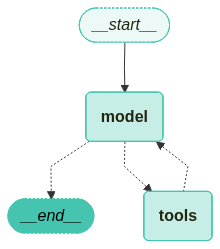

In [16]:
# 그래프 시각화 - 도구가 추가된 것을 확인
visualize_graph(shopping_agent)

In [17]:
# 제품 검색 테스트
stream_graph(
    shopping_agent,
    inputs={
        "messages": [HumanMessage(content="전자기기 카테고리에 어떤 제품들이 있나요?")]
    },
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
【전자기기】 카테고리 제품 목록:

- 아이폰 17 Pro
  가격: 1,990,000원
  평점: 4.5/5.0

- 애플워치 Ultra
  가격: 599,000원
  평점: 4.8/5.0

- 맥북 프로 16인치 M4
  가격: 3,490,000원
  평점: 4.9/5.0

- 아이패드 프로 12.9
  가격: 1,590,000원
  평점: 4.7/5.0

- 에어팟 맥스
  가격: 769,000원
  평점: 4.6/5.0

- 삼성 갤럭시 S25 Ultra
  가격: 1,650,000원
  평점: 4.7/5.0

- 소니 WH-1000XM5 헤드폰
  가격: 429,000원
  평점: 4.8/5.0

- LG 그램 17인치
  가격: 2,190,000원
  평점: 4.5/5.0

- 닌텐도 스위치 OLED
  가격: 415,000원
  평점: 4.6/5.0

- 소니 플레이스테이션 5
  가격: 628,000원
  평점: 4.7/5.0

--- 카테고리 통계 ---
상품 수: 10개
가격 범위: 415,000원 ~ 3,490,000원
평균 평점: 4.7

🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
전자기기 카테고리에는 다음과 같은 제품들이 있습니다:

1. 아이폰 17 Pro - 1,990,000원 (평점 4.5)
2. 애플워치 Ultra - 599,000원 (평점 4.8)
3. 맥북 프로 16인치 M4 - 3,490,000원 (평점 4.9)
4. 아이패드 프로 12.9 - 1,590,000원 (평점 4.7)
5. 에어팟 맥스 - 769,000원 (평점 4.6)
6. 삼성 갤럭시 S25 Ultra - 1,650,000원 (평점 4.7)
7.

In [18]:
# 주문 조회 테스트
stream_graph(
    shopping_agent,
    inputs={
        "messages": [
            HumanMessage(content="주문번호 ORD-2024-001의 배송 상태를 알려주세요.")
        ]
    },
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
주문번호: ORD-2024-001
제품: 아이폰 17 Pro
상태: 배송완료
배송예정일: 2024-12-20
🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
주문번호 ORD-2024-001의 배송 상태는 "배송완료"입니다.
제품: 아이폰 17 Pro
배송예정일: 2024-12-20로 안내되어 있습니다.

이미 배송이 완료된 상태이니, 상품을 잘 받아보셨는지 확인해 주세요. 추가로 궁금하신 점이 있으시면 언제든 문의해 주세요!

In [19]:
# 추천 시스템 테스트
stream_graph(
    shopping_agent,
    inputs={
        "messages": [
            HumanMessage(content="운동을 좋아하는데 어떤 제품을 추천해주시겠어요?")
        ]
    },
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
【스포츠】 카테고리 제품 목록:

- 나이키 에어줌 러닝화
  가격: 169,000원
  평점: 4.7/5.0

- 요가매트 프리미엄 8mm
  가격: 49,000원
  평점: 4.5/5.0

- 덤벨 세트 20kg
  가격: 89,000원
  평점: 4.6/5.0

- 가민 포러너 265 스마트워치
  가격: 549,000원
  평점: 4.8/5.0

- 룰루레몬 레깅스
  가격: 138,000원
  평점: 4.7/5.0

- 테니스 라켓 윌슨 프로
  가격: 289,000원
  평점: 4.5/5.0

- 골프 드라이버 테일러메이드
  가격: 650,000원
  평점: 4.6/5.0

- 캠핑 텐트 4인용
  가격: 320,000원
  평점: 4.4/5.0

- 등산 배낭 45L
  가격: 159,000원
  평점: 4.5/5.0

- 자전거 헬멧
  가격: 89,000원
  평점: 4.6/5.0

--- 카테고리 통계 ---
상품 수: 10개
가격 범위: 49,000원 ~ 650,000원
평균 평점: 4.6

🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
운동을 좋아하신다면 아래와 같은 인기 스포츠 제품들을 추천드립니다:

1. 나이키 에어줌 러닝화 (169,000원, 평점 4.7) – 러닝이나 워킹에 적합한 신발입니다.
2. 요가매트 프리미엄 8mm (49,000원, 평점 4.5) – 요가, 스트레칭 등 실내 운동에 좋아요.
3. 덤벨 세트 20kg (89,000원, 평점 4.6) – 근력 운동을 집에서 간편하게 할 수 있습니다.
4. 가민 포러너 265 스마트워치 (549,000원, 평점 4.8) – 운동 기록, 건강 관리에 탁월한 스마트워치

## 5. 컨텍스트(Context) 관리

컨텍스트를 사용하면 도구가 실행 시점의 추가 정보에 접근할 수 있습니다.

### 실습: 고객 프로필 기반 개인화

고객의 멤버십 등급과 구매 이력을 컨텍스트로 전달하여 개인화된 서비스를 제공합니다.

In [20]:
from dataclasses import dataclass
from langchain.tools import ToolRuntime
from typing import List

# 고객 데이터베이스
CUSTOMER_DB = {
    "yunah": {
        "name": "김윤아",
        "membership": "VIP",
        "purchase_history": ["아이폰 17 Pro", "애플워치 Ultra"],
        "points": 15000,
    },
    "wooyeol": {
        "name": "박우열",
        "membership": "일반",
        "purchase_history": ["청바지"],
        "points": 3000,
    },
    "haseom": {
        "name": "신하섬",
        "membership": "골드",
        "purchase_history": ["맥북 15인치", "진공청소기", "전기밥솥"],
        "points": 8500,
    },
}


@dataclass
class CustomerContext:
    """고객 컨텍스트 정보"""

    customer_id: str


@tool
def get_customer_profile(runtime: ToolRuntime[CustomerContext]) -> str:
    """현재 고객의 프로필 정보를 조회합니다."""
    customer_id = runtime.context.customer_id

    customer = CUSTOMER_DB.get(customer_id)

    if not customer:
        return "고객 정보를 찾을 수 없습니다."

    return (
        f"고객명: {customer['name']}\n"
        f"멤버십: {customer['membership']}\n"
        f"적립금: {customer['points']:,}원\n"
        f"구매이력: {', '.join(customer['purchase_history'])}"
    )


@tool
def get_personalized_discount(runtime: ToolRuntime[CustomerContext]) -> str:
    """고객의 멤버십 등급에 따른 할인 혜택을 확인합니다."""
    customer_id = runtime.context.customer_id
    customer = CUSTOMER_DB.get(customer_id)

    if not customer:
        return "고객 정보를 찾을 수 없습니다."

    membership = customer["membership"]

    discounts = {
        "VIP": "20% 할인 + 무료배송 + 추가 포인트 5배 적립",
        "골드": "15% 할인 + 무료배송 + 추가 포인트 3배 적립",
        "일반": "5% 할인 + 3만원 이상 무료배송",
    }

    return f"{customer['name']}님의 {membership} 혜택:\n{discounts[membership]}"

In [21]:
# 컨텍스트를 사용하는 에이전트 생성
personalized_agent = create_agent(
    model=llm,
    tools=[get_customer_profile, get_personalized_discount, search_products],
    context_schema=CustomerContext,
    system_prompt="""당신은 개인화된 쇼핑 서비스를 제공하는 전문 상담사입니다.
    고객의 프로필과 멤버십 혜택을 활용하여 최적의 쇼핑 경험을 제공하세요.""",
)

In [22]:
# VIP 고객으로 테스트
stream_graph(
    personalized_agent,
    inputs={"messages": [HumanMessage(content="제 프로필과 혜택을 알려주세요.")]},
    context=CustomerContext(customer_id="yunah"),
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
김윤아님의 VIP 혜택:
20% 할인 + 무료배송 + 추가 포인트 5배 적립고객명: 김윤아
멤버십: VIP
적립금: 15,000원
구매이력: 아이폰 17 Pro, 애플워치 Ultra
🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
고객님 프로필 및 혜택 안내드립니다.

프로필 정보
- 고객명: 김윤아
- 멤버십 등급: VIP
- 적립금: 15,000원
- 최근 구매 이력: 아이폰 17 Pro, 애플워치 Ultra

VIP 멤버십 혜택
- 20% 할인
- 무료배송
- 추가 포인트 5배 적립

이 혜택을 활용해 최적의 쇼핑을 도와드릴 수 있습니다. 원하시는 상품이나 카테고리가 있으신가요?

In [23]:
# 일반 고객으로 테스트
stream_graph(
    personalized_agent,
    inputs={
        "messages": [HumanMessage(content="저는 어떤 할인 혜택을 받을 수 있나요?")]
    },
    context=CustomerContext(customer_id="wooyeol"),
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
박우열님의 일반 혜택:
5% 할인 + 3만원 이상 무료배송고객명: 박우열
멤버십: 일반
적립금: 3,000원
구매이력: 청바지
🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
박우열님께서는 현재 일반 멤버십 등급이시며, 다음과 같은 할인 혜택을 받으실 수 있습니다:

- 전 제품 5% 할인
- 3만원 이상 구매 시 무료배송

추가로 궁금하신 점이나 원하시는 상품이 있으시면 언제든 말씀해 주세요! 고객님의 혜택을 최대한 활용할 수 있도록 도와드리겠습니다.

## 6. 구조화된 응답 형식

Pydantic 모델을 사용하여 에이전트의 응답을 특정 스키마에 맞게 구조화할 수 있습니다.

### 실습: 제품 비교 리포트 생성

In [24]:
from pydantic import BaseModel, Field
from typing import List


class ProductComparison(BaseModel):
    """제품 비교 리포트 스키마"""

    product_name: str = Field(description="제품명")
    category: str = Field(description="제품 카테고리")
    price: int = Field(description="가격 (원)")
    rating: float = Field(description="평점 (1-5)")
    pros: List[str] = Field(description="장점 목록")
    cons: List[str] = Field(description="단점 목록")
    recommendation: str = Field(description="추천 의견")

In [25]:
# 구조화된 응답을 사용하는 에이전트
structured_agent = create_agent(
    model=llm,
    tools=[search_products],
    response_format=ProductComparison,
    system_prompt="""제품 정보를 분석하여 구조화된 비교 리포트를 작성하세요.
    장단점을 객관적으로 평가하고 구체적인 추천 의견을 제시하세요.""",
)

In [26]:
# 구조화된 응답 테스트
response = structured_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="전자기기 카테고리에서 아이폰 17 Pro에 대한 상세 리포트를 작성해주세요."
            )
        ]
    }
)

print("=== JSON 응답 ===")
print(response["messages"][-1].content)
print("\n=== 구조화된 객체 ===")
print(response["structured_response"])

=== JSON 응답 ===
{"product_name":"아이폰 17 Pro","category":"전자기기","price":1990000,"rating":4.5,"pros":["최신형 아이폰으로 강력한 성능과 최신 iOS 지원","고급스러운 디자인과 뛰어난 마감 품질","카메라 성능이 대폭 향상되어 사진/영상 촬영에 최적화","생태계 연동(애플워치, 맥북 등)으로 편리한 사용성","디스플레이 품질 및 밝기 우수"],"cons":["경쟁 제품 대비 높은 가격대","배터리 사용 시간이 경쟁 플래그십 대비 다소 아쉬움","충전기 별도 구매 필요","안드로이드 대비 커스터마이징 자유도 낮음"],"recommendation":"최신 스마트폰 중 최고의 성능과 애플 생태계 연동을 원한다면 강력 추천합니다. 다만, 가격이 부담스럽거나 배터리 지속 시간이 최우선이라면 삼성 갤럭시 S25 Ultra 등 경쟁 제품도 고려해볼 만합니다. 애플 기기 사용자, 프리미엄 디자인과 카메라 성능을 중시하는 분께 특히 적합합니다."}

=== 구조화된 객체 ===
product_name='아이폰 17 Pro' category='전자기기' price=1990000 rating=4.5 pros=['최신형 아이폰으로 강력한 성능과 최신 iOS 지원', '고급스러운 디자인과 뛰어난 마감 품질', '카메라 성능이 대폭 향상되어 사진/영상 촬영에 최적화', '생태계 연동(애플워치, 맥북 등)으로 편리한 사용성', '디스플레이 품질 및 밝기 우수'] cons=['경쟁 제품 대비 높은 가격대', '배터리 사용 시간이 경쟁 플래그십 대비 다소 아쉬움', '충전기 별도 구매 필요', '안드로이드 대비 커스터마이징 자유도 낮음'] recommendation='최신 스마트폰 중 최고의 성능과 애플 생태계 연동을 원한다면 강력 추천합니다. 다만, 가격이 부담스럽거나 배터리 지속 시간이 최우선이라면 삼성 갤럭시 S25 Ultra 등 경쟁 제품도 고려해볼 만합니다. 애플 기기 사용자, 프리미엄 디자인과 카메라 성

## 7. 메모리와 대화 상태 관리

체크포인터(Checkpointer)를 사용하여 대화 히스토리를 저장하고 이전 대화를 기억할 수 있습니다.

### thread_id를 통한 대화 세션 관리

동일한 `thread_id`를 사용하면 같은 대화 컨텍스트를 유지할 수 있습니다.

In [27]:
from langgraph.checkpoint.memory import InMemorySaver

# 메모리 체크포인터 생성
memory = InMemorySaver()

In [28]:
# 메모리를 사용하는 에이전트
memory_agent = create_agent(
    model=llm,
    tools=[search_products, check_order_status],
    checkpointer=memory,
    system_prompt="당신은 고객의 이전 대화를 기억하는 쇼핑 도우미입니다.",
)

# 첫 번째 대화 세션
config_session_1 = {"configurable": {"thread_id": "session_001"}}

In [32]:
# 첫 번째 질문
stream_graph(
    memory_agent,
    inputs={
        "messages": [
            HumanMessage(
                content="안녕하세요, 저는 김윤아입니다. 전자기기를 찾고 있어요."
            )
        ]
    },
    config=config_session_1,
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 김윤아님! 전자기기 카테고리에서 인기 있는 제품들을 안내해드릴게요.

• 아이폰 17 Pro – 1,990,000원 (평점 4.5)
• 애플워치 Ultra – 599,000원 (평점 4.8)
• 맥북 프로 16인치 M4 – 3,490,000원 (평점 4.9)
• 아이패드 프로 12.9 – 1,590,000원 (평점 4.7)
• 에어팟 맥스 – 769,000원 (평점 4.6)
• 삼성 갤럭시 S25 Ultra – 1,650,000원 (평점 4.7)
• 소니 WH-1000XM5 헤드폰 – 429,000원 (평점 4.8)
• LG 그램 17인치 – 2,190,000원 (평점 4.5)
• 닌텐도 스위치 OLED – 415,000원 (평점 4.6)
• 소니 플레이스테이션 5 – 628,000원 (평점 4.7)

특정 제품이나 용도가 있으신가요? 아니면 예산이나 관심 있는 브랜드가 있으신가요? 원하시는 조건을 알려주시면 더 맞춤 추천을 도와드릴 수 있습니다!

In [30]:
# 두 번째 질문 (같은 세션)
stream_graph(
    memory_agent,
    inputs={
        "messages": [
            HumanMessage(
                content="제 이름이 뭔지 기억하시나요? 그리고 제가 찾던 카테고리는요?"
            )
        ]
    },
    config=config_session_1,
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네, 고객님의 이름은 김윤아님이고, 찾으시던 카테고리는 "전자기기"입니다.  
필요하신 제품이나 추가로 궁금하신 점 있으시면 언제든 말씀해 주세요!

In [31]:
# 다른 세션에서 질문 (새로운 thread_id)
config_session_2 = {"configurable": {"thread_id": "session_002"}}

stream_graph(
    memory_agent,
    inputs={"messages": [HumanMessage(content="제 이름이 뭔지 아시나요?")]},
    config=config_session_2,
)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네, 이전 대화에서 고객님께서 “지민”이라고 말씀해주셨습니다. 혹시 이름이 변경되었거나 다른 이름을 사용하고 싶으시면 알려주세요!

## 정리

이 노트북에서 배운 LangGraph V1.0의 핵심 개념:

1. **모델 초기화**: `init_chat_model`로 다양한 LLM 통합
2. **에이전트 생성**: `create_agent`로 지능형 시스템 구축
3. **도구 정의**: `@tool` 데코레이터로 외부 기능 연동
4. **컨텍스트 관리**: `ToolRuntime`과 `context_schema`로 실행 환경 정보 전달
5. **구조화된 응답**: Pydantic 모델로 일관된 출력 형식 보장
6. **메모리 관리**: `InMemorySaver`와 `thread_id`로 대화 히스토리 유지